# Lab 4: Diputados 🐷

In [1]:
from IPython.display import HTML
import random

def hide(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Mostrar Código'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide()

<img src='https://images-na.ssl-images-amazon.com/images/I/91Mk%2BWYjgIL._SL1500_.jpg'>

El objetivo de este lab es que pongas en práctica tus habilidades de recopilación de datos usando web scraping, así como tu capacidad de analizar dichos datos ya que la información se ecuentra estructurada.

## Instrucciones
Desarrolla un programa que recopile la información de cada disputado listado en la página de gobernación: http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php y recopila la siguiente información:

* Nombre del diputado
* Entidad que representa
* Partido político
* Correo electrónico
* Nivel de escolaridad (secundaria, preparatoria, universidad, maestría, doctorado)
* Iniciativas presentadas y estatus ante el Pleno (Tipo de presentación, totales y aprobadas)

Una vez que tengas toda la información capturada en dataframe haz un análisis basado en las siguientes puntos (tu puedes proponer más):
* Cantidad de diputados por partido político
* Niveles de escolaridad
* Niveles de escolaridad por partido político
* ¿Cómo se ve la cantidad de propuestas realizadas y aprobadas con respecto a?:
    * Partido político
    * Escolaridad

Nota: Acompaña tus análisis con plots que nutran tu análisis

## Contenido 

* Análisis 
* Web Scraping
* Imports

In [2]:
## all imports
from IPython.display import HTML
import numpy as np
import urllib
import bs4 #this is beautiful soup
import time
import operator
import socket
import re # regular expressions
from urllib.request import urlopen

from pandas import Series
import pandas as pd  #USED
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

import requests

#from selenium import webdriver  #VER DIFERENCIA DESPUES
from bs4 import BeautifulSoup #USED


import requests 

import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')
hide()

# Análisis

### Cargar Datos

In [3]:
df = pd.read_csv('Diputados.csv')
df["Partido"]= df["Partido"].replace('logo_SP.jpg', "Sin Partido") 
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df.head()

,Nombre,Entidad,Partido,Correo,Escolaridad,Total de Iniciativas Presentadas,Total de Iniciativas Aprobadas,i Grupos Parlamentarios P,i Grupos Parlamentarios A,i de Grupo P,i de Grupo A,i Iniciante P,i Iniciante A,i Adherente P,i Adherente A
0,Pedro Daniel Abasolo Sánchez,México,MORENA,pedro.abasolo@diputados.gob.mx,Secundaria,16,10,0,0,15,10,0,0,1,0
1,Brasil Alberto Acosta Peña,México,PRI,brasil.acosta@diputados.gob.mx,Doctorado,45,3,0,0,1,0,1,0,43,3
2,Miguel Acundo González,Puebla,Encuentro Social,miguel.acundo@diputados.gob.mx,Sin registros,24,3,1,1,5,1,7,0,11,1
3,Marco Antonio Adame Castillo,Morelos,PAN,marco.adame@diputados.gob.mx,Maestría,121,6,2,0,27,1,5,0,87,5
4,Heriberto Marcelo Aguilar Castillo,Sonora,MORENA,heriberto.aguilar@diputados.gob.mx,Licenciatura,23,10,1,0,15,10,0,0,7,0


## Diputados por Partido 

In [13]:
dfDiputadosPorPartido = df.groupby('Partido')[['Nombre']].count().reset_index()
dfDiputadosPorPartido.columns=['Partido', 'Cantidad']
dfDiputadosPorPartido = dfDiputadosPorPartido.sort_values('Cantidad', ascending = False)

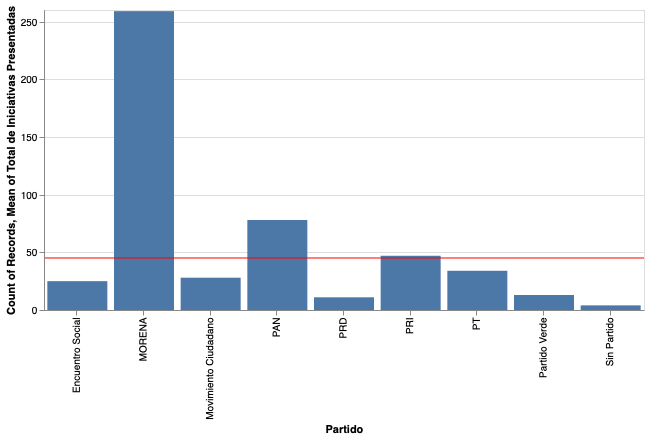

In [6]:
source = df

bar = alt.Chart(source).mark_bar().encode(
    x='Partido:O',
    y='count(Nombre):Q'
)

rule = alt.Chart(source).mark_rule(color='red').encode(
    y='mean(Total de Iniciativas Presentadas):Q'
)

(bar + rule).properties(width=600)


In [26]:
import plotly.offline as pyo
import plotly.graph_objs as go

colors = ['rgb(147, 9, 21)','rgb(20, 39, 232)','rgb(4, 117, 6 )','rgb(247, 0, 0  )','rgb(247, 120, 0)',
         'rgb(139, 0, 247  )','rgb(19, 214, 0  )','rgb(244, 247, 0  )','rgb(97, 107, 107)'] 

fig = go.Figure(data=[go.Bar(
    x= dfDiputadosPorPartido.Partido,
    y= dfDiputadosPorPartido.Cantidad,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(
    title=go.layout.Title(
    text='Número de Diputados por Partido Político'
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="",
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Número de Diputados",
        )
    )
)

In [49]:
import plotly.graph_objects as go
animals=['giraffes', 'orangutans', 'monkeys']

fig = go.Figure([go.Bar(x=animals, y=[20, 14, 23])])
fig.show()

In [17]:
dfDiputadosPorPartido.columns

Index(['TotalDiputados'], dtype='object')

In [68]:





dfPigs = df
dfPigs

,Unnamed: 0,Nombre,Entidad,Partido,Correo,Escolaridad,Total de Iniciativas Presentadas,Total de Iniciativas Aprobadas,i Grupos Parlamentarios P,i Grupos Parlamentarios A,i de Grupo P,i de Grupo A,i Iniciante P,i Iniciante A,i Adherente P,i Adherente A
0,1,Pedro Daniel Abasolo Sánchez,México,MORENA,pedro.abasolo@diputados.gob.mx,Secundaria,16,10,0,0,15,10,0,0,1,0
1,2,Brasil Alberto Acosta Peña,México,PRI,brasil.acosta@diputados.gob.mx,Doctorado,45,3,0,0,1,0,1,0,43,3
2,3,Miguel Acundo González,Puebla,Encuentro Social,miguel.acundo@diputados.gob.mx,Sin registros,24,3,1,1,5,1,7,0,11,1
3,4,Marco Antonio Adame Castillo,Morelos,PAN,marco.adame@diputados.gob.mx,Maestría,121,6,2,0,27,1,5,0,87,5
4,5,Heriberto Marcelo Aguilar Castillo,Sonora,MORENA,heriberto.aguilar@diputados.gob.mx,Licenciatura,23,10,1,0,15,10,0,0,7,0
5,6,Ricardo Aguilar Castillo,México,PRI,raguilar.castillo@diputados.gob.mx,Licenciatura,50,2,1,0,1,0,3,0,45,2
6,7,Bonifacio Aguilar Linda,Veracruz,MORENA,bonifacio.aguilar@diputados.gob.mx,Secundaria,24,11,0,0,15,10,0,0,9,1
7,8,Leticia Arlett Aguilar Molina,Chiapas,MORENA,leticia.aguilar@diputados.gob.mx,Carrera Trunca,20,10,0,0,15,10,2,0,3,0
8,9,Marcos Aguilar Vega,Querétaro,PAN,marcos.aguilar@diputados.gob.mx,Maestría,120,6,3,0,27,1,2,0,88,5
9,10,Adriana Aguilar Vázquez,San Luis Potosí,MORENA,aaguilar.vazquez@diputados.gob.mx,Secundaria,35,11,0,0,15,10,0,0,20,1


In [69]:
dfPigs['animal'] = 'pigs'

In [70]:
dfPigs

,Unnamed: 0,Nombre,Entidad,Partido,Correo,Escolaridad,Total de Iniciativas Presentadas,Total de Iniciativas Aprobadas,i Grupos Parlamentarios P,i Grupos Parlamentarios A,i de Grupo P,i de Grupo A,i Iniciante P,i Iniciante A,i Adherente P,i Adherente A,animal
0,1,Pedro Daniel Abasolo Sánchez,México,MORENA,pedro.abasolo@diputados.gob.mx,Secundaria,16,10,0,0,15,10,0,0,1,0,pigs
1,2,Brasil Alberto Acosta Peña,México,PRI,brasil.acosta@diputados.gob.mx,Doctorado,45,3,0,0,1,0,1,0,43,3,pigs
2,3,Miguel Acundo González,Puebla,Encuentro Social,miguel.acundo@diputados.gob.mx,Sin registros,24,3,1,1,5,1,7,0,11,1,pigs
3,4,Marco Antonio Adame Castillo,Morelos,PAN,marco.adame@diputados.gob.mx,Maestría,121,6,2,0,27,1,5,0,87,5,pigs
4,5,Heriberto Marcelo Aguilar Castillo,Sonora,MORENA,heriberto.aguilar@diputados.gob.mx,Licenciatura,23,10,1,0,15,10,0,0,7,0,pigs
5,6,Ricardo Aguilar Castillo,México,PRI,raguilar.castillo@diputados.gob.mx,Licenciatura,50,2,1,0,1,0,3,0,45,2,pigs
6,7,Bonifacio Aguilar Linda,Veracruz,MORENA,bonifacio.aguilar@diputados.gob.mx,Secundaria,24,11,0,0,15,10,0,0,9,1,pigs
7,8,Leticia Arlett Aguilar Molina,Chiapas,MORENA,leticia.aguilar@diputados.gob.mx,Carrera Trunca,20,10,0,0,15,10,2,0,3,0,pigs
8,9,Marcos Aguilar Vega,Querétaro,PAN,marcos.aguilar@diputados.gob.mx,Maestría,120,6,3,0,27,1,2,0,88,5,pigs
9,10,Adriana Aguilar Vázquez,San Luis Potosí,MORENA,aaguilar.vazquez@diputados.gob.mx,Secundaria,35,11,0,0,15,10,0,0,20,1,pigs


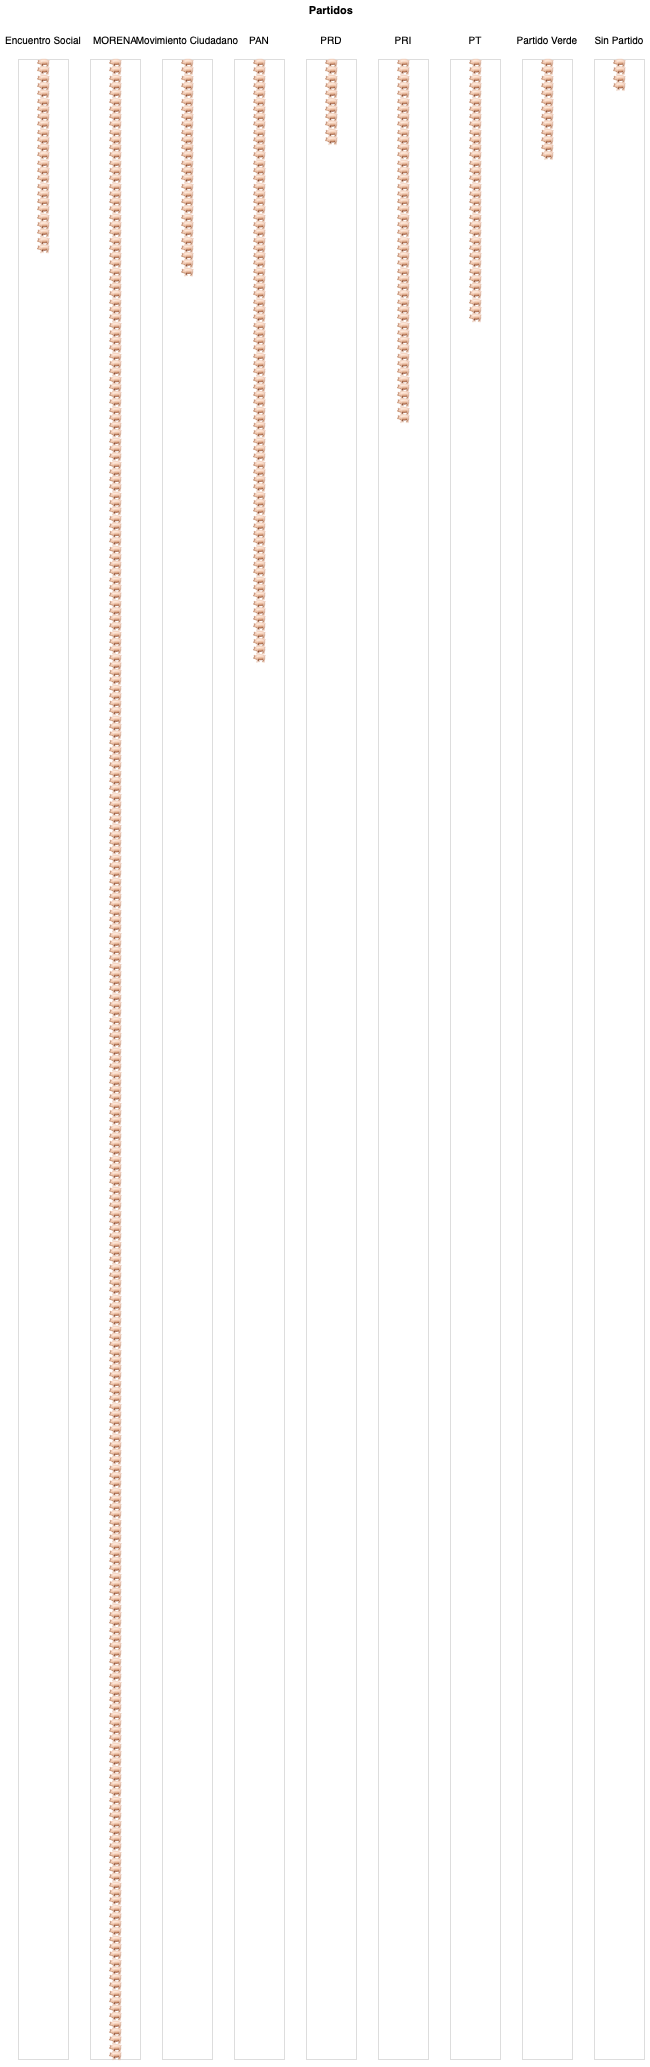

In [71]:
alt.Chart(dfPigs).mark_text(size=10, baseline='middle').encode(
    alt.X('animal:O', axis=None),
    alt.Y('y:O', axis=None),
    alt.Column('Partido:N', header=alt.Header(title='Partidos')),
    alt.Text('emoji:N')
).transform_calculate(
    emoji="{'pigs': '🐖'}[datum.animal]"
).transform_window(
    y='rank()',
    groupby=['Partido', 'animal']
).properties(width=50, height=2000)

# Escolaridad por Partido Político

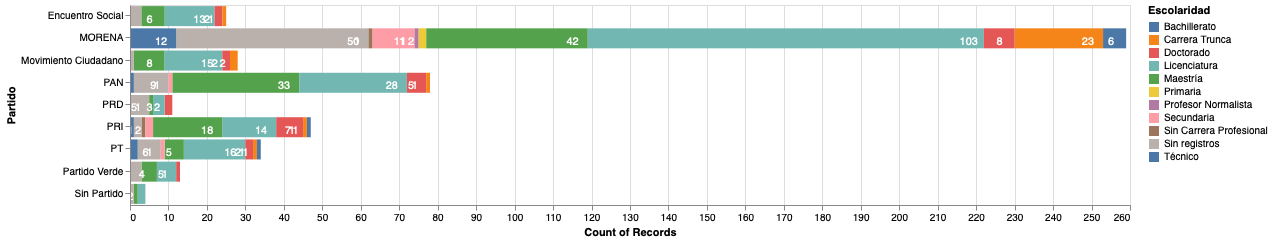

In [72]:
bars = alt.Chart(df).mark_bar().encode(
    x=alt.X('count(Nombre):Q', stack='zero'),
    y=alt.Y('Partido:N'),
    color=alt.Color('Escolaridad')
).properties(width=1000, height=200)

text = alt.Chart(df).mark_text(dx=-15, dy=3, color='white').encode(
    x=alt.X('count(Nombre):Q', stack='zero'),
    y=alt.Y('Partido:N'),
    detail='Escolaridad:N',
    text=alt.Text('count(Nombre):Q')
)

bars + text

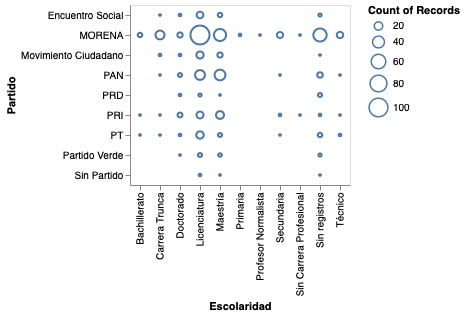

In [73]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Nombre)'
)

In [74]:
df['Escolaridad'].value_counts()

Licenciatura               199
Maestría                   118
Sin registros               80
Doctorado                   29
Carrera Trunca              29
Técnico                     16
Secundaria                  15
Bachillerato                 8
Sin Carrera Profesional      2
Primaria                     2
Profesor Normalista          1
Name: Escolaridad, dtype: int64

# Propuestas realizadas por Partido Politico y Escolaridad

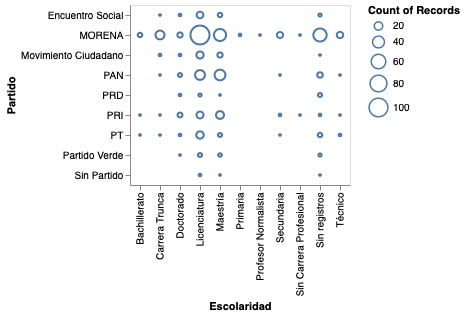

In [75]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Total de Iniciativas Presentadas)'
)

# Propuestas aprobadas por Partido Politico y Escolaridad

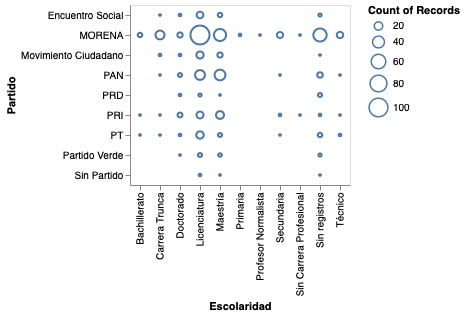

In [76]:
alt.Chart(df).mark_point().encode(
    x='Escolaridad',
    y='Partido',
    size='count(Total de Iniciativas Aprobadas)'
)

In [77]:
source

,Unnamed: 0,Nombre,Entidad,Partido,Correo,Escolaridad,Total de Iniciativas Presentadas,Total de Iniciativas Aprobadas,i Grupos Parlamentarios P,i Grupos Parlamentarios A,i de Grupo P,i de Grupo A,i Iniciante P,i Iniciante A,i Adherente P,i Adherente A,animal
0,1,Pedro Daniel Abasolo Sánchez,México,MORENA,pedro.abasolo@diputados.gob.mx,Secundaria,16,10,0,0,15,10,0,0,1,0,pigs
1,2,Brasil Alberto Acosta Peña,México,PRI,brasil.acosta@diputados.gob.mx,Doctorado,45,3,0,0,1,0,1,0,43,3,pigs
2,3,Miguel Acundo González,Puebla,Encuentro Social,miguel.acundo@diputados.gob.mx,Sin registros,24,3,1,1,5,1,7,0,11,1,pigs
3,4,Marco Antonio Adame Castillo,Morelos,PAN,marco.adame@diputados.gob.mx,Maestría,121,6,2,0,27,1,5,0,87,5,pigs
4,5,Heriberto Marcelo Aguilar Castillo,Sonora,MORENA,heriberto.aguilar@diputados.gob.mx,Licenciatura,23,10,1,0,15,10,0,0,7,0,pigs
5,6,Ricardo Aguilar Castillo,México,PRI,raguilar.castillo@diputados.gob.mx,Licenciatura,50,2,1,0,1,0,3,0,45,2,pigs
6,7,Bonifacio Aguilar Linda,Veracruz,MORENA,bonifacio.aguilar@diputados.gob.mx,Secundaria,24,11,0,0,15,10,0,0,9,1,pigs
7,8,Leticia Arlett Aguilar Molina,Chiapas,MORENA,leticia.aguilar@diputados.gob.mx,Carrera Trunca,20,10,0,0,15,10,2,0,3,0,pigs
8,9,Marcos Aguilar Vega,Querétaro,PAN,marcos.aguilar@diputados.gob.mx,Maestría,120,6,3,0,27,1,2,0,88,5,pigs
9,10,Adriana Aguilar Vázquez,San Luis Potosí,MORENA,aaguilar.vazquez@diputados.gob.mx,Secundaria,35,11,0,0,15,10,0,0,20,1,pigs


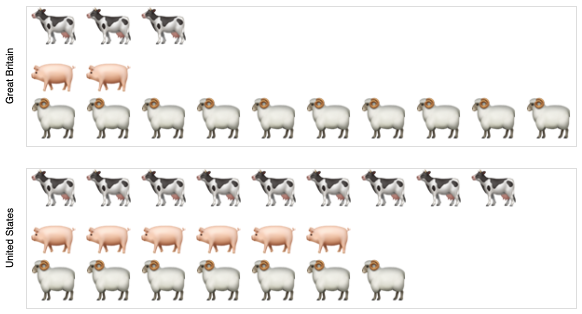

In [78]:
import altair as alt
alt.renderers.enable('notebook')

source = pd.DataFrame([
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'cattle'},
      {'country': 'Great Britain', 'animal': 'pigs'},
      {'country': 'Great Britain', 'animal': 'pigs'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'Great Britain', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'cattle'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'pigs'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'},
      {'country': 'United States', 'animal': 'sheep'}
    ])


alt.Chart(source).mark_text(size=45, baseline='middle').encode(
    alt.X('x:O', axis=None),
    alt.Y('animal:O', axis=None),
    alt.Row('country:N', header=alt.Header(title='')),
    alt.Text('emoji:N')
).transform_calculate(
    emoji="{'cattle': '🐄', 'pigs': '🐖', 'sheep': '🐏'}[datum.animal]"
).transform_window(
    x='rank()',
    groupby=['country', 'animal']
).properties(width=550, height=140)

chromedriver = "/Users/jaimesolis/Downloads/chromedriver-2"
driver = webdriver.Chrome(chromedriver)
driver.get("https://google.com")


#### BeautifulSoup Object

In [79]:
import requests 

In [80]:
r = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php')

In [81]:
from bs4 import BeautifulSoup 
soup = BeautifulSoup(r.text, 'html.parser') 

In [82]:
print (soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script language="JavaScript" src="./javascripts/anim_imag.js" type="text/javascript">
  </script>
  <link href="./include/styles_diputados.css" rel="stylesheet" type="text/css"/>
  <link href="./include/formatonvo.css" rel="stylesheet" type="text/css"/>
  <title>
   Listado de Diputados LXIV
  </title>
 </head>
 <body leftmargin="0" topmargin="0">
  <table align="center" border="0" cellpadding="0" cellspacing="0">
   <tr>
    <td>
     <tr>
      <td valign="top" width="760">
       <img border="0" height="115" src="images/cabezalLXIV.png" width="760"/>
      </td>
     </tr>
     <tr>
      <td colspan="3">
       <table border="0" cellpadding="0" cellspacing="0" width="760">
        <tr>
         <td align="center" bgcolor="#595843" class="textoBlanco" width="175">
          24/09/2019
         

## Lista de elementos donde esta el sublink

In [83]:
lista1 = soup.find_all('a', attrs={'class':'linkVerde'}) #Obtiene el elemento donde esta el link
del lista1[0] #borramamos el primero que encuentra <a class="linkVerde" href="info_diputados.php">Regresar</a>
len(lista1) #Verificar que tenemos 499 elementos

499

### Test para obtener el primer link

In [84]:
test = lista1[0] #Probar antes de hacer loop
testlink = test['href'] #devuelve curricula.php?dipt=484 de href="curricula.php?dipt=484

## Lista de Sublinks 

In [85]:
links = []
for element in lista1:
    link = element['href']
    links.append(link)

In [86]:
len(links)

499

### Test para obtener la info del primero diputado

In [87]:
r = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/' + testlink )
soup2 = BeautifulSoup(r.text, 'html.parser')
print(soup2.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script language="JavaScript" src="./javascripts/anim_imag.js" type="text/javascript">
  </script>
  <link href="./include/styles_diputados.css" rel="stylesheet" type="text/css"/>
  <link href="./include/formatonvo.css" rel="stylesheet" type="text/css"/>
  <title>
   Curricula LXIV
  </title>
  <style>
   .fondoimg {
background:url(images/fondo_fot_5.png) no-repeat center fixed;
-webkit-background-size: cover;
-moz-background-size: cover;
-o-background-size: cover;
background-size: cover;
}
.fondoimg2 {
background-image: url(images/fondo_fot_7.png);
  -webkit-background-size: 100% 100%;           /* Safari 3.0 */
     -moz-background-size: 100% 100%;           /* Gecko 1.9.2 (Firefox 3.6) */
       -o-background-size: 100% 100%;           /* Opera 9.5 */
          background-size: 100% 100%;       

#### NOMBRE

In [88]:
elemento = soup2.find('td',{'class': 'textocurrienc', 'height': '23'}) 
elemento

<td class="textocurrienc" colspan="2" height="23"><center><strong>Dip. Pedro Daniel Abasolo Sánchez</strong></center></td>

In [89]:
testNombre = elemento.center.strong.text[5:]
testNombre

'Pedro Daniel Abasolo Sánchez'

#### ENTIDAD

In [90]:
soup2.find_all('td', {'width': '470', 'class':'textocurri'})

[<td class="textocurri" width="470"><strong>Representación proporcional</strong></td>,
 <td class="textocurri" width="470"><strong>México </strong>
 
    <b>|</b>  Circunscripción:   
 <strong>5 </strong>
 
    <b>|</b>   </td>,
 <td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>,
 <td class="textocurri" width="470"><strong>3-febrero </strong></td>,
 <td class="textocurri" width="470">Carlos Alejandro Mendoza Álvarez
 					
 
 
  </td>]

In [91]:
elemento = soup2.find_all('td', {'width': '470', 'class':'textocurri'})
elemento = elemento[1]
elemento


<td class="textocurri" width="470"><strong>México </strong>

   <b>|</b>  Circunscripción:   
<strong>5 </strong>

   <b>|</b>   </td>

In [92]:
elemento.strong.text

'México '

In [93]:
testEntidad = elemento.strong.text
testEntidad

'México '

#### PARTIDO POLITICO

In [94]:
elemento = soup2.find('img', {'width': '80'})
elemento

<img height="80" src="images/LogoMorena.jpg" width="80"/>

In [95]:
elemento['src']

'images/LogoMorena.jpg'

In [96]:
testPartido= elemento['src']
testPartido = testPartido[7:]
testPartido

'LogoMorena.jpg'

#### CORREO ELECTRONICO 

In [97]:
soup2.find_all('td', {'width': '470', 'class': 'textocurri'})

[<td class="textocurri" width="470"><strong>Representación proporcional</strong></td>,
 <td class="textocurri" width="470"><strong>México </strong>
 
    <b>|</b>  Circunscripción:   
 <strong>5 </strong>
 
    <b>|</b>   </td>,
 <td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>,
 <td class="textocurri" width="470"><strong>3-febrero </strong></td>,
 <td class="textocurri" width="470">Carlos Alejandro Mendoza Álvarez
 					
 
 
  </td>]

In [98]:
elemento = soup2.find_all('td', {'width': '470', 'class': 'textocurri'})
elemento = elemento[2]
elemento

<td class="textocurri" width="470"><strong>pedro.abasolo@diputados.gob.mx </strong></td>

In [99]:
testCorreo =elemento.strong.text
testCorreo

'pedro.abasolo@diputados.gob.mx '

#### Escolaridad

Encontrar tag de Escolaridad y si lo encuentra encontrar el maximo nivel de estudios

Si tiene escolaridad, buscar el nivel máximo que tenga. 

In [100]:
#elemento = soup2.find('td', {'class':'TitulosVerde'})
elemento = soup2.find(text='ESCOLARIDAD')
print(elemento)
#elemento.text

ESCOLARIDAD


In [101]:
if soup2.find(text='ESCOLARIDAD'):
    elementoEscolaridad = soup2.find('td', {'class':'TitulosVerde'}).findNext('td')
    testEscolaridad = elementoEscolaridad.text
else: 
    testEscolaridad = 'Sin registros'
testEscolaridad

'Secundaria'

In [102]:
if soup2.find(text='Doctorado'):
    testEscolaridad = 'Doctorado'
elif soup2.find(text='Maestría'):
    testEscolaridad = 'Maestría'
elif soup2.find(text='Licenciatura'):
    testEscolaridad = 'Licenciatura'
elif soup2.find(text='Bachillerato'):
    testEscolaridad = 'Bachillerato'
elif soup2.find(text='Secundaria'):
    testEscolaridad = 'Secundaria'
elif soup2.find(text='Primaria'):
    testEscolaridad = 'Secundaria'
elif soup2.find(text='ESCOLARIDAD'):
    elementoEscolaridad = soup2.find('td', {'class':'TitulosVerde'}).findNext('td')
    testEscolaridad = elementoEscolaridad.text
else: 
    testEscolaridad = 'Sin registros'
testEscolaridad

'Secundaria'

#### PROPUESTAS POR TIPO

In [103]:
r3 = requests.get('http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=282')
soup3 = BeautifulSoup(r3.text, 'html.parser')

In [104]:
soup2.find_all(text='Tipo de presentación')

['Tipo de presentación', 'Tipo de presentación']

In [105]:
test=soup2.find_all(text='Tipo de presentación')
test = test[1] #el segundo porque el primero es otra parte que no es visible 
propuestas = test.findNext('tr')
propuestas

<tr bgcolor="#E3DAC1">
<td align="center" class="textoNegro" width="150">Adherente</td>
<td align="center" bgcolor="#cccccc" class="textoNegro" width="100">1 </td>
<td align="center" class="textoNegro" width="100"><b>0</b></td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>0</b> </td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>1</b></td>
<tr bgcolor="#FFFFFF">
<td align="center" class="textoNegro" width="150">De Grupo</td>
<td align="center" bgcolor="#cccccc" class="textoNegro" width="100">15 </td>
<td align="center" class="textoNegro" width="100"><b>10</b></td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>0</b> </td>
<td align="center" class="textoNegro" width="100">0</td>
<td align="center" class="textoNegro" width="100"><b>5</b></td>
</tr>
<tr bgcolor="#E3DAC1">
<td align="center" class="te

##### a) Diversos Grupos Parlamentarios

In [106]:
if propuestas.find(text='Diversos Grupos Parlamentarios'):
    ElementoGruposParlamentariosP = propuestas.find(text='Diversos Grupos Parlamentarios')
    ElementoGruposParlamentariosA = ElementoGruposParlamentariosT.findNext('td')
    
    testGruposParlamentariosP = int(ElementoGruposParlamentariosP.findNext('td').text)
    testGruposParlamentariosA = int(ElementoGruposParlamentariosA.findNext('td').text)
else: 
    testGruposParlamentariosP = 0
    testGruposParlamentariosA = 0

In [107]:
testGruposParlamentariosP

0

##### b) De grupo

In [108]:
if propuestas.find(text='De Grupo'):
    ElementoDeGrupoP = propuestas.find(text='De Grupo')
    ElementoDeGrupoA = ElementoDeGrupoP.findNext('td')
    
    testDeGrupoP = int(ElementoDeGrupoP.findNext('td').text)
    testDeGrupoA = int(ElementoDeGrupoA.findNext('td').text)
else: 
    testDeGrupoP = 0
    testDeGrupoA = 0

In [109]:
print(testDeGrupoA)

10


##### c) Iniciante

In [110]:
if propuestas.find(text='Iniciante'):
    ElementoInicianteP = propuestas.find(text='Iniciante')
    ElementoInicianteA = ElementoInicianteT.findNext('td')
    
    testInicianteP = int(ElementoInicianteP.findNext('td').text)
    testInicianteA = int(ElementoInicianteA.findNext('td').text)
else: 
    testInicianteP = 0
    testInicianteA = 0

##### d) Adherente 

In [111]:
if propuestas.find(text='Adherente'):
    ElementoAdherenteP = propuestas.find(text='Adherente')
    ElementoAdherenteA = ElementoAdherenteP.findNext('td')
    
    testAdherenteP = int(ElementoAdherenteP.findNext('td').text)
    testAdherenteA = int(ElementoAdherenteA.findNext('td').text)
else: 
    testAdherenteP = 0
    testAdherenteA = 0

#### Totales

In [112]:
testTotalesP=testGruposParlamentariosP+testDeGrupoP+testInicianteP+testAdherenteP
testTotalesA=testGruposParlamentariosA+testDeGrupoA+testInicianteA+testAdherenteA


Como ya funcionan los test de un diputado, podemos proceder a hacerlo con todos

# Scraping de Diputados

In [ ]:
df = pd.DataFrame(data, columns=['Nombre','Entidad','Partido','Correo','Escolaridad',
                                 'Total de Iniciativas Presentadas','Total de Iniciativas Aprobadas',
                                 'i Grupos Parlamentarios P', 'i Grupos Parlamentarios A','i de Grupo P', 
                                 'i de Grupo A', 'i Iniciante P', 'i Iniciante A', 'i Adherente P', 'i Adherente A'])

### Limpiar nombres de Partidos

In [ ]:
df["Partido"]= df["Partido"].replace('LogoMorena.jpg', "MORENA") 
df["Partido"]= df["Partido"].replace('pri01.png', "PRI") 
df["Partido"]= df["Partido"].replace('encuentro.png', "Encuentro Social") 
df["Partido"]= df["Partido"].replace('pan.png', "PAN") 
df["Partido"]= df["Partido"].replace('prd01.png', "PRD") 
df["Partido"]= df["Partido"].replace('logvrd.jpg', "Partido Verde") 
df["Partido"]= df["Partido"].replace('Logo_PT.png', "PT") 
df["Partido"]= df["Partido"].replace('logo_movimiento_ciudadano.png', "Movimiento Ciudadano") 
df


In [ ]:
index=list(range(1,500))
df.index = index

In [ ]:
df.groupby('Partido')['Nombre'].count()

In [ ]:
df[df['Partido']=='logo_SP.jpg']

In [ ]:
df["Partido"]= df["Partido"].replace('logo_SP.jpg', "Sin Partido") 

In [ ]:
df[['Nombre', 'Escolaridad']].head(100)

### Limpiar Escolaridad

In [ ]:
df["Escolaridad"]= df["Escolaridad"].replace('Bachillerato ', "Bachillerato") 

In [ ]:
dfEscolaridadLimpiar = df[['Nombre', 'Escolaridad']][(df['Escolaridad']!= 'Doctorado') & 
                                                     (df['Escolaridad']!= 'Maestría') & 
                                                     (df['Escolaridad']!= 'Licenciatura') & 
                                                     (df['Escolaridad']!= 'Bachillerato') & 
                                                     (df['Escolaridad']!= 'Secundaria') & 
                                                     (df['Escolaridad']!= 'Primaria') & 
                                                     (df['Escolaridad']!= 'Carrera Trunca') & 
                                                      (df['Escolaridad']!= 'Técnico') & 
                                                     (df['Escolaridad']!= 'Sin registros')]
dfEscolaridadLimpiar

In [ ]:
df["Escolaridad"]= df["Escolaridad"].replace('Bachillerato | Nivel Medio Superior', "Bachillerato") 

In [ ]:
df.set_value(24, 'Escolaridad', 'Sin Carrera Profesional') 
df.set_value(53, 'Escolaridad', 'Licenciatura') 
df.set_value(263, 'Escolaridad', 'Profesor Normalista') 
df.set_value(359, 'Escolaridad', 'Sin Carrera Profesional') 

In [ ]:
pd.crosstab(df['Escolaridad'], 'Numero de diputados').sort_values(by=['Numero de diputados'], ascending=False)

In [ ]:
df.to_csv('Diputados.csv')